Here I only use AD and HC data and following discussion today (on Dec 21, 2023), 

And I project the X(t) to the SC Laplacian eigvetors U. 

$U^T X'(t) = \Lambda U^T X(t)$

Here I try to estimate continous lambda not change points

But I only use first 210 ROIs (subcortial rois are excluded) (on Mar 12, 2024)

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap
from splines import obt_bsp_basis_Rfn_wrapper

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd
from joblib import Parallel, delayed
from IPython.display import display

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu

def _get_test_tb(res_df, base_grp_id=6):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    base = res_df["metric"][res_df["diagnosis"]==base_grp_id]
    grp_name = diag_lab_mapping[base_grp_id]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    diag_ix =  np.setdiff1d([1, 6], [base_grp_id])[0]
    DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
    ttest_res = ttest_ind(DS, base)
    ttest_res1 = mannwhitneyu(DS, base)
    effect_size = (np.mean(DS)-np.mean(base))/np.std(np.concatenate([DS, base]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs {grp_name}", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    tb.add_row([f"(non-param) {indicator(ttest_res1.pvalue)}{diag_lab_mapping[diag_ix]} vs {grp_name}", 
                    f"{ttest_res1.pvalue:>6.3f}", 
                    f"{effect_size:>6.3f}"])
    
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb


In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts[:210]
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [7]:
# load data
num_rois = 210 # the BNA has 246 regions, but I only use first 210
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");
SC_mat = loadmat(DATA_ROOT/"SC_HC_BN_template_nature_order.mat")["SC_template"][:num_rois, :num_rois];
Dmat_invhalffrac = np.diag(1/(SC_mat.sum(axis=0)**0.5))
Lap_mat = np.eye(num_rois) - Dmat_invhalffrac @ SC_mat @ Dmat_invhalffrac
# col is the eig vectors
eigvals, eigvecs = np.linalg.eigh(Lap_mat); 
sort_idx = np.argsort(np.abs(eigvals))
eigvals, eigvecs = eigvals[sort_idx], eigvecs[:, sort_idx]


# some parameters

num_sps = 321
ac_time = 485

485

In [8]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

# only need AD and HC grp
sub_data_idxs = np.bitwise_or(diag_labs==1, diag_labs == 6);
diag_labs_sub = diag_labs[sub_data_idxs];
sex_labs_sub = sex_labs[sub_data_idxs];
mmse_scores_sub = mmse_scores[sub_data_idxs];

# Run gTVDN

In [9]:
save_dir = RES_ROOT/"congTVDN2grp_projsc_210test"
if not save_dir.exists():
    save_dir.mkdir()

In [10]:
paras = edict()
# these two are most influential
#paras.lamb = 1e-7
paras.lamb = 1e-6
#paras.lamb = 1e-6
#paras.lamb = 5e-5
# r is moderately influential
paras.r = 20 
# not very important
# N is the num of basis for B spline
#paras.N = 25
paras.N = 35
# order of B spline, do not change it. 
paras.bsp_ord = 4
paras.T = 1


basis_fn = lambda ts: obt_bsp_basis_Rfn_wrapper(ts, N=paras.N, bsp_ord=paras.bsp_ord);

In [11]:
save_pkl(save_dir/"paras.pkl", paras, is_force=True)

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_210test/paras.pkl


## Get data

In [12]:
# get all ts data and divide them into different group
# note the ts are preprocessed (detrend and resample)
from collections import defaultdict as ddict
all_data = []
for sub_ix in range(num_sps):
    ts = _load_data(sub_ix+1)[:num_rois]
    ts = _preprocess_ts(ts);
    all_data.append(ts)
all_data = np.array(all_data);

# only choose 2 grps
all_data = all_data[sub_data_idxs];

In [13]:
# normalized the time to make it within [0, 1]
time_span = np.linspace(0, paras.T, all_data[0].shape[-1])
basis = basis_fn(time_span);

## Bspline

In [14]:
from gTVDN.gtvdn_utils import get_bspline_est
dXXmats = {}
dXmats, Xmats = get_bspline_est(np.array(all_data), time_span, paras.lamb, n_jobs=20);
dXXmats["dXmats"] = dXmats
dXXmats["Xmats"] = Xmats;
    
save_pkl(save_dir/"dXXmats.pkl", dXXmats, is_force=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38220/38220 [00:06<00:00, 5529.52it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_210test/dXXmats.pkl


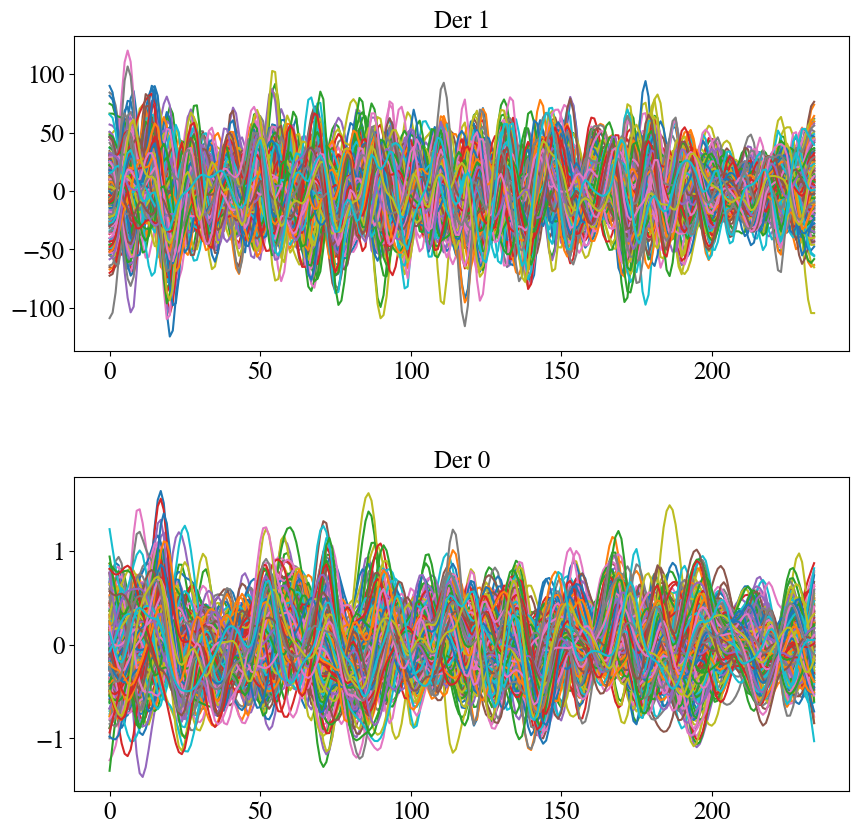

In [15]:
sub_ix = 0 
dXmat = dXmats[sub_ix]
Xmat = Xmats[sub_ix];

plt.figure(figsize=[10, 10])
plt.subplot(211)
plt.title("Der 1")
for roi_ix in range(num_rois):
    plt.plot(dXmat[roi_ix])
plt.subplot(212)
plt.title("Der 0")
for roi_ix in range(num_rois):
    plt.plot(Xmat[roi_ix])

## Detection

###  Reduce the dim of data

In [16]:
dXXmats =load_pkl(save_dir/"dXXmats.pkl");
nXmats = eigvecs[:, :paras.r].T @ dXXmats["Xmats"]
ndXmats = eigvecs[:, :paras.r].T @ dXXmats["dXmats"];

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_210test/dXXmats.pkl


In [51]:
std_fn = lambda x: (x-x.min())/(x.max()-x.min())
eig_ix = 7
vec = eigvecs[:, eig_ix];

vec_std = std_fn(np.abs(vec))
vec_std = np.concatenate([vec_std, np.zeros(36)]);
np.savetxt(MIDRES_ROOT/f"raj_scmat210_absnet.txt", vec_std)

vec_std = std_fn(vec)
vec_std = np.concatenate([vec_std, np.zeros(36)]);
np.savetxt(MIDRES_ROOT/f"raj_scmat210_rawnet.txt", vec_std)

### Estimate lam(t)

In [17]:
def get_gam_est(sY, sX, basis, ridge_pen=0):
    """Get gam est based on sY sX and basis
    args:
        sY (array): T vec
        sX (array): T vec
        basis (array): T x N matrix, the bspline basis
    we aim to find a gam vec with N x 1 such that np.mean((sY-basis@gam_est .* sX)**2) is minimal
    return: 
        gam_est (array): N vec
    """
    
    rvec = ((sY * sX)[:, None] * basis).sum(axis=0);
    wbasis = (sX[:, None] * basis);
    lmat = wbasis.T @ wbasis + ridge_pen*np.eye(wbasis.shape[1]);
    gam_est = np.linalg.pinv(lmat) @ rvec;
    return gam_est

In [18]:
def get_gam_est_mul(Y, X, basis, ridge_pen=0):
    """Get gam est based on Y X and basis
    args:
        sY (array): dxT mat
        sX (array): dxT mat
        basis (array): T x N matrix, the bspline basis
    return: 
        gam_ests (array): d x N mat 
    """
    
    d = Y.shape[0]
    gam_ests = []
    for d_ix in range(d):
        sY = Y[d_ix]
        sX = X[d_ix]
        gam_est = get_gam_est(sY, sX, basis, ridge_pen=ridge_pen)
        gam_ests.append(gam_est)
    return np.array(gam_ests)

In [19]:
def _run_fn(sub_ix):
    gam_ests = get_gam_est_mul(ndXmats[sub_ix], nXmats[sub_ix], basis, 0.0);
    lam_ests = basis @ gam_ests.T;
    return lam_ests
with Parallel(n_jobs=20) as parallel:
    cpts = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(nXmats.shape[0]), total=nXmats.shape[0]))
    
save_pkl(save_dir/"lam_ests.pkl", cpts, is_force=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 1393.00it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_210test/lam_ests.pkl


Text(0, 0.5, 'Lam(t)')

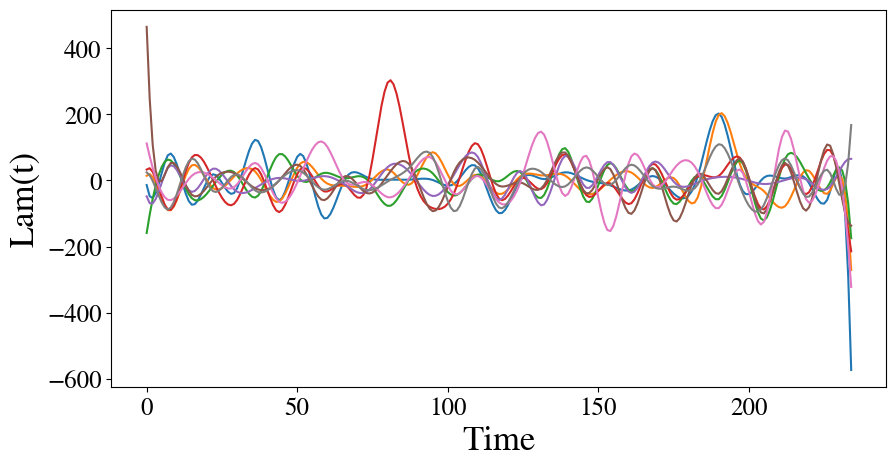

In [20]:
lam_est = cpts[1]
for ix in range(8):
    plt.plot(lam_est[:, ix])
plt.xlabel("Time")
plt.ylabel("Lam(t)")

# Analysis

In [21]:

save_dir = RES_ROOT/"congTVDN2grp_projsc_210test/"
paras = load_pkl(save_dir/"paras.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_210test/paras.pkl


In [22]:
lam_ests = load_pkl(save_dir/"lam_ests.pkl");
dXXmats =load_pkl(save_dir/"dXXmats.pkl");
nXmats = eigvecs[:, :paras.r].T @ dXXmats["Xmats"]
ndXmats = eigvecs[:, :paras.r].T @ dXXmats["dXmats"];

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_210test/lam_ests.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_210test/dXXmats.pkl


Text(0, 0.5, 'Lam(t)')

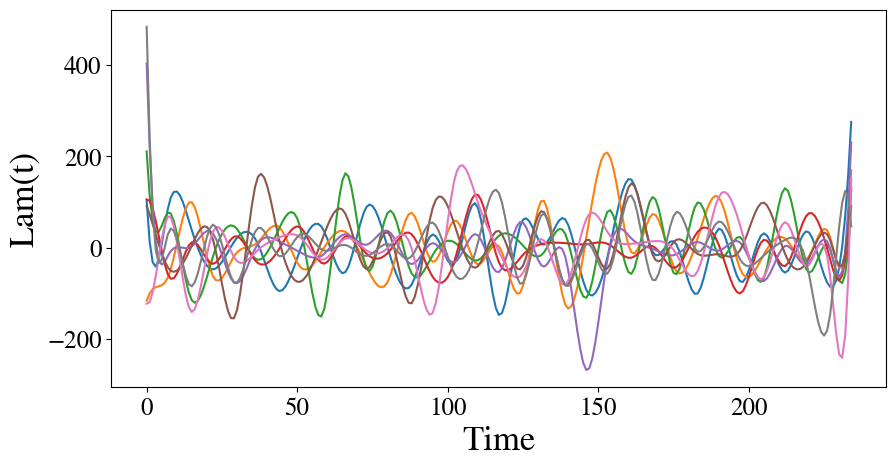

In [23]:
lam_est = lam_ests[0]
for ix in range(8):
    plt.plot(lam_est[:, ix])
plt.xlabel("Time")
plt.ylabel("Lam(t)")

## Correlation

In [42]:
def _get_dftb(metric):
    res_df = pd.DataFrame({
        "metric": metric,
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    return res_df

In [24]:
corr_fs = []
for lam_est in lam_ests:
    mat = np.corrcoef(lam_est.T);
    idxs = np.triu_indices_from(mat, k=1)
    corr_fs.append(np.max(np.abs(mat[idxs])))

In [25]:
res_df = pd.DataFrame({
    "metric": corr_fs, 
    "sex": sex_labs_sub, 
    "diagnosis": diag_labs_sub
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.468,-0.108
(non-param) AD vs HC,0.281,-0.108


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.620468,0.085616,0.453922,0.553785,0.597674,0.679341,0.830937
HC,100.0,0.629733,0.085531,0.439456,0.571557,0.623361,0.678444,0.933390


## cpts

In [26]:
def get_cpts(lam_est):
    """Get cpts based on lam est
    args:
        lam_est (array): T x r mat
    return:
        cpts_raw: the cpts and corresponding Uix (from 0)
    """
    raw_segs = np.argmax(np.abs(lam_est), axis=1);
    # i is a cpt if changes start at i
    # index is from 0
    cpts_raw = np.where(np.diff(raw_segs)!=0)[0]+1
    cpts_raw_full = np.concatenate([[0], cpts_raw, [lam_est.shape[0]]])
    return cpts_raw_full, raw_segs[cpts_raw_full[:-1]]

In [27]:
Lmin = 5 
ncpt_fn = lambda cpts: np.sum(np.diff(cpts) > Lmin)-1
ncpt_fn = lambda cpts: len(cpts)-2

cptss = []
Uidxs = []
for lam_est in lam_ests:
    cptss.append(get_cpts(lam_est)[0])
    Uidxs.append(get_cpts(lam_est)[1])
ncpts = np.array([ncpt_fn(cpts) for cpts in cptss]);

In [28]:
res_df = pd.DataFrame({
    "metric": ncpts, 
    "sex": sex_labs_sub, 
    "diagnosis": diag_labs_sub
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.866,-0.025
(non-param) AD vs HC,0.843,-0.025


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,61.695122,4.339565,49.0,59.0,62.0,65.0,71.0
HC,100.0,61.810000,4.741169,51.0,59.0,62.0,64.0,73.0


## Dwell time

In [29]:
dwells =[np.diff(cpts) for cpts in cptss];
max_dwells = np.array([np.max(dwell) for dwell in dwells]);
mean_dwells = np.array([np.mean(dwell) for dwell in dwells]);

In [30]:
# get the dwell time for each U
dwells_perU = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perU[sub_ix, u_ix] = np.sum(dwell[Uidx==u_ix])
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df = pd.DataFrame({
        "metric": dwells_perU[:, u_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.676,0.062
(non-param) AD vs HC,0.534,0.062


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.268293,8.250774,0.0,6.0,12.0,18.00,33.0
HC,100.0,11.750000,8.358598,0.0,5.0,11.0,15.25,44.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.201,-0.190
(non-param) AD vs HC,0.337,-0.190


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.95122,7.947206,0.0,5.00,10.5,18.0,38.0
HC,100.0,13.66000,9.679949,0.0,7.75,12.5,18.0,44.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.272,-0.164
(non-param) AD vs HC,0.285,-0.164


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.219512,7.858352,0.0,4.00,8.5,15.75,32.0
HC,100.0,11.580000,8.618960,0.0,5.75,10.0,16.00,52.0


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.127,0.227
(non-param) AD vs HC,0.084,0.227


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.012195,7.508832,0.0,6.25,12.0,16.00,32.0
HC,100.0,10.400000,6.669696,0.0,6.00,9.0,13.25,32.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.642,-0.069
(non-param) AD vs HC,0.652,-0.069


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.926829,9.085031,0.0,5.25,11.5,18.0,42.0
HC,100.0,13.570000,9.417644,0.0,5.00,12.5,21.0,34.0


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.992,0.001
(non-param) AD vs HC,0.792,0.001


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.573171,9.865804,0.0,5.0,10.0,16.75,52.0
HC,100.0,11.560000,8.654210,0.0,5.0,10.0,15.25,39.0


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.664,0.065
(non-param) AD vs HC,0.583,0.065


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.292683,7.273303,0.0,5.0,11.0,17.0,29.0
HC,100.0,10.830000,7.022410,0.0,6.0,10.0,15.0,32.0


lam ix is 7:


Test,Pval,Effect size
*AD vs HC,0.049,-0.292
(non-param) *AD vs HC,0.039,-0.292


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.219512,7.445314,0.0,5.0,9.0,13.0,35.0
HC,100.0,12.570000,8.369322,0.0,6.0,12.0,18.0,42.0


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.806,-0.037
(non-param) AD vs HC,0.764,-0.037


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.012195,8.309587,0.0,5.25,11.0,17.75,39.0
HC,100.0,12.320000,8.451741,0.0,5.00,12.0,18.00,42.0


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.498,0.101
(non-param) AD vs HC,0.504,0.101


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.353659,8.339068,0.0,6.0,12.0,17.75,41.0
HC,100.0,11.540000,7.794611,0.0,6.0,10.0,16.00,37.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.651,-0.068
(non-param) AD vs HC,0.785,-0.068


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.121951,7.548020,0.0,6.0,10.0,15.0,37.0
HC,100.0,11.660000,8.286803,0.0,6.0,10.0,15.0,37.0


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.990,-0.002
(non-param) AD vs HC,0.833,-0.002


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.573171,8.310384,0.0,5.25,10.5,17.0,34.0
HC,100.0,11.590000,8.862696,0.0,6.00,10.0,15.0,42.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.762,0.045
(non-param) AD vs HC,0.962,0.045


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.195122,8.612995,0.0,5.0,10.0,16.0,37.0
HC,100.0,10.830000,7.597255,0.0,5.0,10.0,16.0,28.0


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.404,0.124
(non-param) AD vs HC,0.574,0.124


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.47561,8.337370,0.0,4.00,11.0,18.75,32.0
HC,100.0,10.53000,6.909889,0.0,5.75,10.0,15.00,32.0


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.133,-0.223
(non-param) AD vs HC,0.189,-0.223


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.634146,8.165740,0.0,4.25,10.5,14.0,32.0
HC,100.0,12.690000,9.869548,0.0,5.00,11.5,18.0,44.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.337,0.143
(non-param) AD vs HC,0.600,0.143


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,13.390244,9.725563,1.0,5.25,10.5,19.0,43.0
HC,100.0,12.130000,7.924715,0.0,5.00,10.5,18.0,33.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.508,0.099
(non-param) AD vs HC,0.552,0.099


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.463415,8.539227,0.0,6.0,11.0,17.75,33.0
HC,100.0,11.650000,7.954892,0.0,6.0,11.0,16.00,35.0


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.329,0.146
(non-param) AD vs HC,0.382,0.146


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.865854,9.132444,0.0,7.0,11.0,17.00,39.0
HC,100.0,11.570000,8.671624,0.0,5.0,10.0,16.25,39.0


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.407,0.124
(non-param) AD vs HC,0.353,0.124


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.341463,8.359543,0.0,6.00,11.0,17.0,40.0
HC,100.0,11.310000,8.315369,0.0,4.75,10.0,17.0,31.0


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.906,-0.018
(non-param) AD vs HC,0.984,-0.018


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.109756,8.360705,0.0,4.0,10.0,16.00,35.0
HC,100.0,11.260000,8.667389,0.0,5.0,9.5,15.25,42.0


In [31]:
# get the dwell time for each U
dwells_perUm = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perUm[sub_ix, u_ix] = np.mean(dwell[Uidx==u_ix]) if (Uidx==u_ix).sum() > 0 else 0
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df = pd.DataFrame({
        "metric": dwells_perUm[:, u_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.555,-0.088
(non-param) AD vs HC,0.387,-0.088


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.403368,1.841881,0.0,2.5,3.225000,4.321429,10.0
HC,100.0,3.555754,1.631415,0.0,2.5,3.666667,4.500000,10.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.532,-0.093
(non-param) AD vs HC,0.475,-0.093


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.538095,1.677350,0.0,2.333333,3.333333,4.475000,8.5
HC,100.0,3.703671,1.852594,0.0,2.750000,3.645833,4.666667,10.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.373,-0.133
(non-param) AD vs HC,0.444,-0.133


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.317073,1.891989,0.0,2.000000,3.416667,4.4375,9.0
HC,100.0,3.575690,1.981950,0.0,2.321429,3.291667,4.5000,10.0


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.794,0.039
(non-param) AD vs HC,0.854,0.039


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.595616,1.899235,0.0,2.5,3.666667,4.333333,13.0
HC,100.0,3.527143,1.631534,0.0,2.5,3.366667,4.541667,8.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.697,-0.058
(non-param) AD vs HC,0.582,-0.058


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.399971,1.594832,0.0,2.2,3.5,4.428571,8.0
HC,100.0,3.495040,1.674197,0.0,2.5,3.5,4.500000,8.0


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.287,-0.159
(non-param) AD vs HC,0.511,-0.159


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.436910,1.793222,0.0,2.500,3.645833,4.5,9.0
HC,100.0,3.741976,2.011599,0.0,2.625,3.666667,4.8,12.0


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.856,-0.027
(non-param) AD vs HC,0.757,-0.027


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.545833,1.760960,0.0,2.5,3.612500,4.625,10.0
HC,100.0,3.595413,1.880422,0.0,2.5,3.416667,4.500,10.0


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.679,-0.062
(non-param) AD vs HC,0.492,-0.062


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.599724,2.102631,0.0,2.270833,3.416667,4.5,9.0
HC,100.0,3.724210,1.937672,0.0,2.575000,3.600000,5.0,11.0


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.692,-0.059
(non-param) AD vs HC,0.361,-0.059


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.375494,1.877162,0.0,2.500,3.250000,4.25,9.0
HC,100.0,3.476333,1.557159,0.0,2.575,3.583333,4.50,7.0


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.812,0.035
(non-param) AD vs HC,0.774,0.035


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.583362,2.047088,0.0,2.270833,3.500000,4.5,10.0
HC,100.0,3.517250,1.700430,0.0,2.650000,3.333333,4.5,8.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.523,-0.095
(non-param) AD vs HC,0.666,-0.095


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.523258,1.717860,0.0,2.000000,3.535714,4.787500,7.5
HC,100.0,3.698060,1.923788,0.0,2.458333,3.500000,4.678571,9.0


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.643,0.069
(non-param) AD vs HC,0.993,0.069


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.529602,1.930315,0.0,2.05,3.416667,4.95,8.5
HC,100.0,3.405202,1.680419,0.0,2.50,3.500000,4.50,8.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.538,0.092
(non-param) AD vs HC,0.720,0.092


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.412485,2.084469,0.0,2.00,3.366667,4.500,10.0
HC,100.0,3.238619,1.713783,0.0,2.15,3.225000,4.425,7.0


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.286,0.159
(non-param) AD vs HC,0.407,0.159


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.542417,1.933155,0.0,2.041667,3.401786,4.75,10.0
HC,100.0,3.253175,1.713221,0.0,2.250000,3.309524,4.00,8.5


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.581,-0.082
(non-param) AD vs HC,0.524,-0.082


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.327570,1.756474,0.0,2.333333,3.312500,4.3625,8.0
HC,100.0,3.471579,1.742980,0.0,2.550000,3.535714,4.5000,8.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.103,0.242
(non-param) AD vs HC,0.166,0.242


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.945281,1.962956,1.0,2.500000,3.708333,5.0,11.0
HC,100.0,3.500373,1.697928,0.0,2.458333,3.414286,4.5,10.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.454,0.112
(non-param) AD vs HC,0.250,0.112


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.608638,1.698132,0.0,2.666667,3.816667,5.0,7.0
HC,100.0,3.414405,1.766028,0.0,2.500000,3.450000,4.5,9.0


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.758,0.046
(non-param) AD vs HC,0.985,0.046


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.695180,1.825017,0.0,2.666667,3.535714,4.843750,10.0
HC,100.0,3.611667,1.807561,0.0,2.500000,3.937500,4.517857,11.0


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.265,0.166
(non-param) AD vs HC,0.270,0.166


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.708188,2.185338,0.0,2.500000,3.666667,4.666667,11.0
HC,100.0,3.368500,1.914601,0.0,2.333333,3.187500,4.270833,9.0


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.525,-0.095
(non-param) AD vs HC,0.702,-0.095


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.310453,1.666194,0.0,2.083333,3.708333,4.250000,7.5
HC,100.0,3.466893,1.631691,0.0,2.500000,3.500000,4.616667,7.0


In [32]:
# get the dwell time for each U
dwells_perUmax = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perUmax[sub_ix, u_ix] = np.max(dwell[Uidx==u_ix]) if (Uidx==u_ix).sum() > 0 else 0
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df = pd.DataFrame({
        "metric": dwells_perUmax[:, u_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.569,-0.085
(non-param) AD vs HC,0.674,-0.085


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.414634,2.897215,0.0,4.0,6.0,7.0,12.0
HC,100.0,5.660000,2.875251,0.0,3.0,6.0,8.0,13.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.219,-0.183
(non-param) AD vs HC,0.188,-0.183


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.45122,2.615964,0.0,3.0,6.0,7.0,10.0
HC,100.0,5.97000,2.982965,0.0,4.0,6.0,8.0,13.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.539,-0.092
(non-param) AD vs HC,0.580,-0.092


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.158537,3.093081,0.0,2.0,5.0,8.0,11.0
HC,100.0,5.430000,2.847132,0.0,3.0,6.0,8.0,12.0


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.767,0.044
(non-param) AD vs HC,0.713,0.044


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.597561,2.711930,0.0,4.0,6.0,7.00,13.0
HC,100.0,5.480000,2.607216,0.0,3.0,5.5,7.25,11.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.906,-0.018
(non-param) AD vs HC,0.960,-0.018


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.658537,2.763159,0.0,4.0,6.0,8.0,13.0
HC,100.0,5.710000,3.059329,0.0,3.0,6.0,8.0,13.0


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.291,-0.157
(non-param) AD vs HC,0.309,-0.157


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.280488,2.961791,0.0,3.00,6.0,7.0,12.0
HC,100.0,5.740000,2.876656,0.0,3.75,6.0,8.0,12.0


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.393,0.127
(non-param) AD vs HC,0.263,0.127


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.621951,2.870197,0.0,3.00,6.0,8.0,11.0
HC,100.0,5.280000,2.514925,0.0,3.75,5.5,7.0,11.0


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.129,-0.226
(non-param) AD vs HC,0.100,-0.226


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.182927,2.863685,0.0,3.0,5.0,7.0,12.0
HC,100.0,5.840000,2.915372,0.0,4.0,6.0,8.0,11.0


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.545,-0.090
(non-param) AD vs HC,0.389,-0.090


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.329268,2.914650,0.0,4.0,5.0,7.0,13.0
HC,100.0,5.590000,2.864252,0.0,3.0,6.0,8.0,11.0


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.947,-0.010
(non-param) AD vs HC,0.941,-0.010


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.402439,2.779376,0.0,3.25,5.0,8.00,11.0
HC,100.0,5.430000,2.767981,0.0,3.00,6.0,7.25,12.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.482,-0.105
(non-param) AD vs HC,0.407,-0.105


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.353659,2.727871,0.0,3.0,5.5,7.0,12.0
HC,100.0,5.650000,2.896794,0.0,4.0,6.0,8.0,12.0


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.678,-0.062
(non-param) AD vs HC,0.726,-0.062


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.195122,2.768603,0.0,3.0,5.0,7.75,10.0
HC,100.0,5.370000,2.866226,0.0,4.0,6.0,8.00,13.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.409,0.123
(non-param) AD vs HC,0.346,0.123


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.439024,3.285199,0.0,3.0,6.0,8.0,14.0
HC,100.0,5.060000,2.894858,0.0,3.0,5.0,7.0,12.0


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.700,0.058
(non-param) AD vs HC,0.509,0.058


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.268293,2.811128,0.0,3.00,6.0,7.0,12.0
HC,100.0,5.110000,2.700150,0.0,3.75,5.0,7.0,11.0


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.254,-0.170
(non-param) AD vs HC,0.226,-0.170


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.012195,2.813082,0.0,3.0,5.0,7.0,10.0
HC,100.0,5.490000,2.790659,0.0,3.0,6.0,8.0,11.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.504,0.100
(non-param) AD vs HC,0.726,0.100


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.939024,3.011696,1.0,3.0,6.0,8.0,15.0
HC,100.0,5.650000,2.797456,0.0,3.0,6.0,8.0,14.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.633,0.071
(non-param) AD vs HC,0.667,0.071


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.695122,2.853151,0.0,4.0,6.0,7.0,12.0
HC,100.0,5.490000,2.897212,0.0,4.0,5.5,8.0,12.0


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.731,-0.051
(non-param) AD vs HC,0.590,-0.051


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.585366,2.680295,0.0,4.0,6.0,7.75,11.0
HC,100.0,5.730000,2.922760,0.0,4.0,6.0,8.00,11.0


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.479,0.106
(non-param) AD vs HC,0.722,0.106


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.597561,3.030136,0.0,4.0,6.0,7.0,15.0
HC,100.0,5.280000,2.978305,0.0,3.0,6.0,8.0,11.0


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.447,-0.113
(non-param) AD vs HC,0.415,-0.113


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.987805,2.782192,0.0,3.0,5.0,7.0,11.0
HC,100.0,5.300000,2.717322,0.0,3.0,5.0,8.0,10.0


In [33]:
res_df = pd.DataFrame({
    "metric": max_dwells, 
    "sex": sex_labs_sub, 
    "diagnosis": diag_labs_sub
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.286,0.159
(non-param) AD vs HC,0.389,0.159


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.47561,1.459119,8.0,10.0,10.0,11.0,15.0
HC,100.0,10.26000,1.260271,8.0,9.0,10.0,11.0,14.0


In [34]:
res_df = pd.DataFrame({
    "metric": mean_dwells, 
    "sex": sex_labs_sub, 
    "diagnosis": diag_labs_sub
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.936,0.012
(non-param) AD vs HC,0.843,0.012


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.766625,0.269506,3.263889,3.560606,3.730159,3.916667,4.700000
HC,100.0,3.763235,0.293524,3.175676,3.615385,3.730159,3.916667,4.519231


## Mean lam(t) over time 

In [35]:
lam_ests_mean = np.array([np.mean(lam_est, axis=0) for lam_est in lam_ests]);

for lam_ix in range(lam_ests_mean.shape[1]):
    res_df = pd.DataFrame({
        "metric": lam_ests_mean[:, lam_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {lam_ix}:")
    display(_get_test_tb(res_df))
    #display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.567,-0.085
(non-param) AD vs HC,0.794,-0.085


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.576,0.083
(non-param) AD vs HC,0.441,0.083


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.179,0.200
(non-param) AD vs HC,0.260,0.200


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.526,-0.095
(non-param) AD vs HC,0.470,-0.095


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.732,-0.051
(non-param) AD vs HC,0.988,-0.051


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.218,0.183
(non-param) AD vs HC,0.308,0.183


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.414,0.122
(non-param) AD vs HC,0.256,0.122


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.746,0.048
(non-param) AD vs HC,0.658,0.048


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.849,-0.028
(non-param) AD vs HC,0.687,-0.028


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.158,-0.210
(non-param) AD vs HC,0.140,-0.210


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.878,-0.023
(non-param) AD vs HC,0.831,-0.023


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.948,-0.010
(non-param) AD vs HC,0.970,-0.010


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.922,0.015
(non-param) AD vs HC,0.781,0.015


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.851,0.028
(non-param) AD vs HC,0.862,0.028


lam ix is 14:


Test,Pval,Effect size
*AD vs HC,0.047,0.294
(non-param) AD vs HC,0.053,0.294


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.502,0.100
(non-param) AD vs HC,0.662,0.100


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.388,0.129
(non-param) AD vs HC,0.718,0.129


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.930,-0.013
(non-param) AD vs HC,0.789,-0.013


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.291,0.157
(non-param) AD vs HC,0.418,0.157


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.929,0.013
(non-param) AD vs HC,0.880,0.013


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'HC'}>

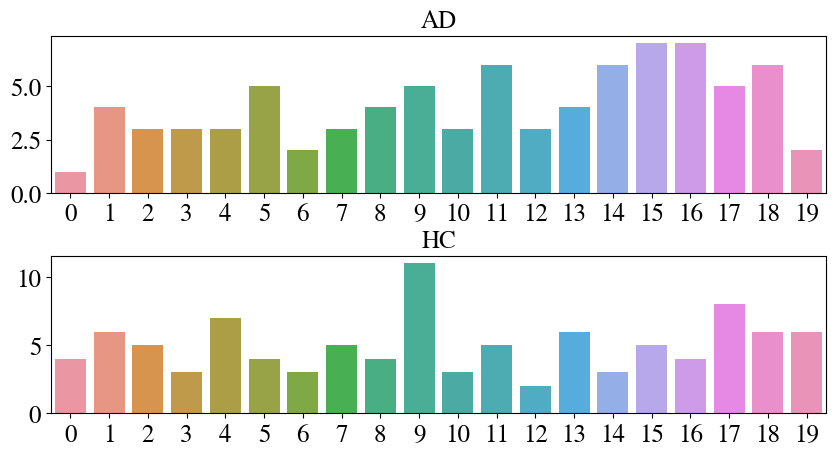

In [41]:
max_abs_idxs = np.argmax(lam_ests_mean, axis=1)
grp1 = np.unique(max_abs_idxs[diag_labs_sub==1], return_counts=True)
grp2 = np.unique(max_abs_idxs[diag_labs_sub==6], return_counts=True);

plt.figure(figsize=[10, 5])
plt.subplot(211)
plt.title(f"{diag_lab_mapping[1]}")
sns.barplot(grp1[0], grp1[1])
plt.subplot(212)
plt.title(f"{diag_lab_mapping[6]}")
sns.barplot(grp2[0], grp2[1])

Text(0, 0.5, 'mean(lam(t))')

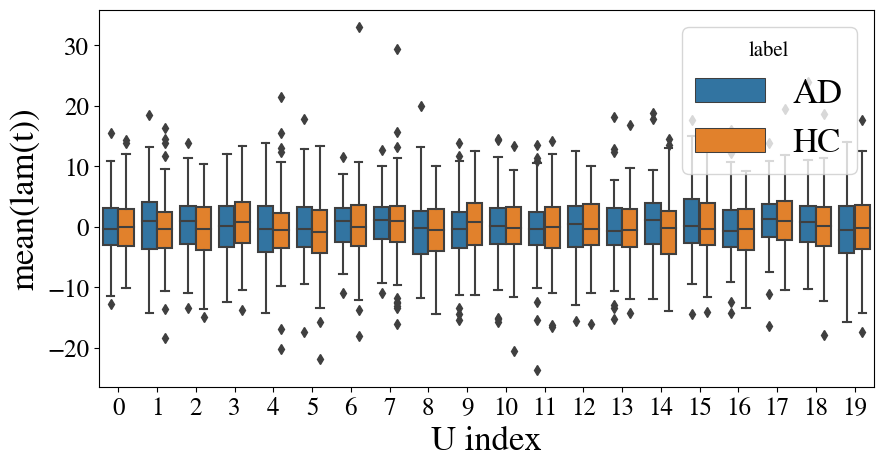

In [42]:

vs = []
labs = []
lamixs = []
for lam_ix in range(lam_ests_mean.shape[1]):
    cur_v = lam_ests_mean[:, lam_ix]
    cur_lb = diag_labs_sub
    cur_lamix = [lam_ix] * len(cur_v)
    vs.append(cur_v)
    labs.append(cur_lb)
    lamixs.append(cur_lamix)

df = pd.DataFrame({
    "v": np.concatenate(vs),
    "labs": np.concatenate(labs),
    "lamixs": np.concatenate(lamixs)
})
df["label"] = df["labs"].map(lambda x: diag_lab_mapping[x])
sns.boxplot(data=df, y="v", x="lamixs", hue="label")
plt.xlabel("U index")
plt.ylabel("mean(lam(t))")

In [36]:
lam_ests_mean_abs = np.array([np.mean(np.abs(lam_est), axis=0) for lam_est in lam_ests]);

for lam_ix in range(lam_ests_mean_abs.shape[1]):
    res_df = pd.DataFrame({
        "metric": lam_ests_mean_abs[:, lam_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {lam_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.311,0.151
(non-param) AD vs HC,0.375,0.151


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.20008,7.658135,23.192213,33.965451,39.060142,43.98614,61.016462
HC,100.0,38.14704,6.330936,25.480588,33.664007,37.795941,43.10827,55.437786


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.888,-0.021
(non-param) AD vs HC,0.943,-0.021


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.550167,8.031358,21.976129,33.487563,38.856586,45.354222,59.204170
HC,100.0,39.726601,8.650011,22.242449,33.311164,39.386761,44.270377,65.069964


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.575,0.084
(non-param) AD vs HC,0.524,0.084


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.353901,7.580491,24.260124,33.539000,37.669882,42.542733,68.784109
HC,100.0,37.718589,7.590780,20.062065,32.565957,37.065449,41.859215,60.700011


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.096,0.247
(non-param) AD vs HC,0.106,0.247


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.565884,7.548854,25.021459,34.206454,39.325559,45.063076,62.926359
HC,100.0,37.768232,6.921147,20.435104,33.254069,37.365003,42.435920,61.381364


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.645,0.069
(non-param) AD vs HC,0.787,0.069


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,41.224496,8.084778,19.166179,36.102111,40.230619,45.326451,62.959536
HC,100.0,40.652566,8.484836,22.583668,34.389184,40.564520,46.979079,62.573323


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.492,-0.102
(non-param) AD vs HC,0.334,-0.102


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.240137,9.289782,22.478845,30.944548,37.642175,43.869271,70.847031
HC,100.0,39.096582,7.485847,24.120680,33.681486,38.276459,42.909748,58.897929


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.203,-0.189
(non-param) AD vs HC,0.375,-0.189


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.625933,6.612345,20.834166,33.007538,38.373591,43.095616,50.208149
HC,100.0,39.036489,8.011223,18.321927,33.331589,39.586642,43.065271,72.206415


lam ix is 7:


Test,Pval,Effect size
*AD vs HC,0.024,-0.333
(non-param) *AD vs HC,0.020,-0.333


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,36.999084,7.678886,23.159878,30.680984,36.656083,41.650419,59.098580
HC,100.0,39.697736,8.220420,22.238905,34.087520,39.985311,44.020992,64.470691


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.692,0.059
(non-param) AD vs HC,0.855,0.059


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.906260,7.307556,23.959354,32.642272,39.055876,43.437546,59.692289
HC,100.0,38.474929,7.273363,23.155994,33.439311,37.978107,43.146928,59.877486


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.357,0.137
(non-param) AD vs HC,0.212,0.137


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.825549,8.326020,19.259971,34.576939,40.465612,45.055372,62.126443
HC,100.0,38.712400,7.907382,23.802260,33.302303,38.343004,43.102141,60.500098


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.543,-0.091
(non-param) AD vs HC,0.563,-0.091


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.720806,6.992377,22.714067,33.580700,37.364308,42.133953,58.035010
HC,100.0,38.405460,7.945683,19.571726,32.925602,37.872586,43.887441,57.239347


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.959,0.008
(non-param) AD vs HC,0.770,0.008


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.468014,7.952444,22.10274,31.834444,35.650581,42.921796,63.376055
HC,100.0,37.406640,8.207338,18.40505,32.122124,36.613403,41.514608,60.708236


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.675,0.063
(non-param) AD vs HC,0.537,0.063


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.548919,7.752999,18.931926,33.777878,37.702183,43.889194,57.838632
HC,100.0,38.082092,7.204904,23.240758,32.683496,37.632313,42.263917,58.249971


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.445,0.114
(non-param) AD vs HC,0.507,0.114


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.504813,7.699991,21.550539,32.796903,37.190332,44.146477,56.343001
HC,100.0,37.653947,7.245622,23.504538,31.942131,37.081427,42.526168,58.282399


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.088,-0.254
(non-param) AD vs HC,0.159,-0.254


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.414548,6.845802,18.241222,32.117514,37.332922,41.804932,55.923798
HC,100.0,39.362772,8.187291,22.975273,33.372463,38.993027,44.094358,60.207211


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.727,0.052
(non-param) AD vs HC,0.796,0.052


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.364654,9.487757,25.002957,33.352970,37.855882,44.099885,78.165640
HC,100.0,38.926246,7.438977,18.204961,33.463332,38.487814,43.651200,69.873482


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.930,-0.013
(non-param) AD vs HC,0.740,-0.013


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.422067,8.004040,26.013761,32.751457,39.133809,45.306661,56.042715
HC,100.0,39.517511,6.625464,21.905042,35.684249,40.018534,44.088100,52.095122


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.220,0.182
(non-param) AD vs HC,0.216,0.182


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.637995,8.246130,23.272578,34.442628,39.772565,45.264809,62.016533
HC,100.0,38.177491,7.743097,21.402403,32.074003,38.048747,42.332343,60.149597


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.216,0.184
(non-param) AD vs HC,0.218,0.184


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.032876,7.807846,21.424173,33.146819,38.770512,44.248376,62.749133
HC,100.0,37.592188,7.771112,19.482539,32.590465,37.038118,42.721533,55.382006


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.986,-0.003
(non-param) AD vs HC,0.952,-0.003


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.199278,7.690356,25.634107,33.895768,38.165751,44.156258,62.753283
HC,100.0,39.220669,8.608558,17.591303,33.125084,38.349271,43.557110,63.790784


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'HC'}>

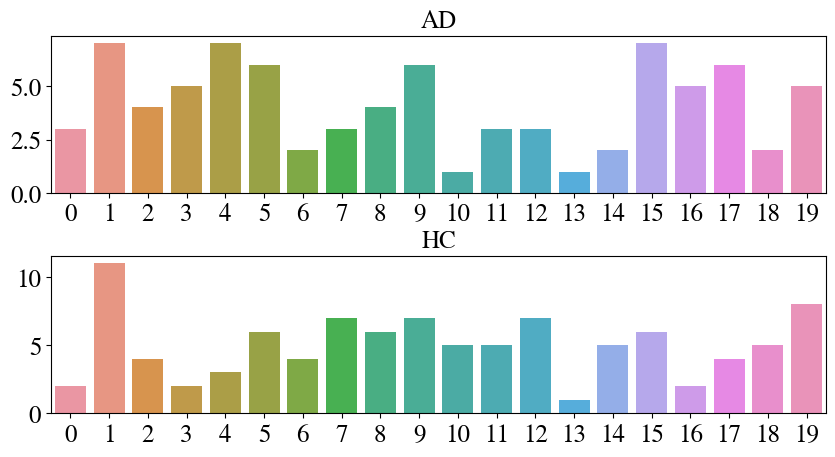

In [44]:
max_abs_idxs = np.argmax(lam_ests_mean_abs, axis=1)
grp1 = np.unique(max_abs_idxs[diag_labs_sub==1], return_counts=True)
grp2 = np.unique(max_abs_idxs[diag_labs_sub==6], return_counts=True);

plt.figure(figsize=[10, 5])
plt.subplot(211)
plt.title(f"{diag_lab_mapping[1]}")
sns.barplot(grp1[0], grp1[1])
plt.subplot(212)
plt.title(f"{diag_lab_mapping[6]}")
sns.barplot(grp2[0], grp2[1])

Text(0, 0.5, 'mean(lam(t))')

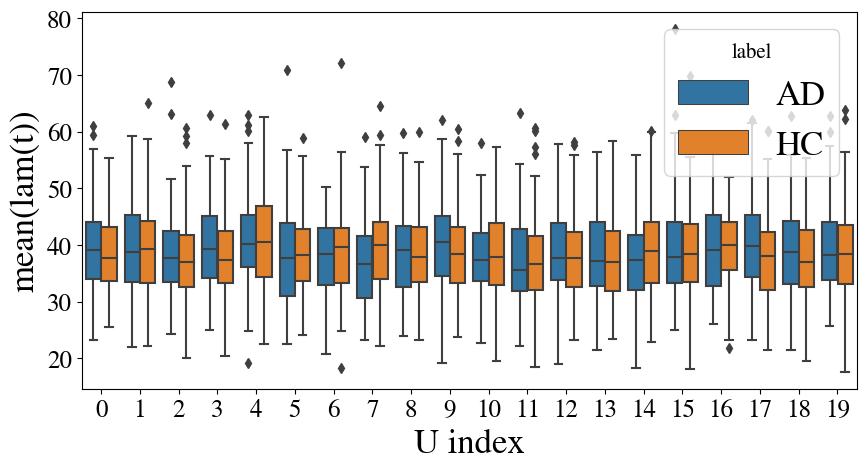

In [45]:

vs = []
labs = []
lamixs = []
for lam_ix in range(lam_ests_mean_abs.shape[1]):
    cur_v = lam_ests_mean_abs[:, lam_ix]
    cur_lb = diag_labs_sub
    cur_lamix = [lam_ix] * len(cur_v)
    vs.append(cur_v)
    labs.append(cur_lb)
    lamixs.append(cur_lamix)

df = pd.DataFrame({
    "v": np.concatenate(vs),
    "labs": np.concatenate(labs),
    "lamixs": np.concatenate(lamixs)
})
df["label"] = df["labs"].map(lambda x: diag_lab_mapping[x])
sns.boxplot(data=df, y="v", x="lamixs", hue="label")
plt.xlabel("U index")
plt.ylabel("mean(lam(t))")

In [37]:
def _fs_fn(lam_est, typ=1, is_abs=False):
    if is_abs:
        lam_est = np.abs(lam_est)
        
    if typ == 1:
        return np.mean(lam_est)
    elif typ == 2:
        return np.median(lam_est)
    elif typ == 3:
        return np.mean(lam_est, axis=0).max()
    elif typ == 4:
        return np.median(lam_est, axis=0).max()




for typ in [1, 2, 3, 4]:
    for is_abs in [True, False]:
        fs = np.array([_fs_fn(lam_est, typ=typ, is_abs=is_abs) for lam_est in lam_ests]);
        res_df = pd.DataFrame({
            "metric": fs,
            "sex": sex_labs_sub, 
            "diagnosis": diag_labs_sub
        })
        res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
        display(_get_test_tb(res_df))
        #display(res_df.groupby("diagnosis1")["metric"].describe())

Test,Pval,Effect size
AD vs HC,0.705,0.057
(non-param) AD vs HC,0.757,0.057


Test,Pval,Effect size
AD vs HC,0.220,0.182
(non-param) AD vs HC,0.174,0.182


Test,Pval,Effect size
AD vs HC,0.732,0.051
(non-param) AD vs HC,0.672,0.051


Test,Pval,Effect size
AD vs HC,0.968,-0.006
(non-param) AD vs HC,0.693,-0.006


Test,Pval,Effect size
AD vs HC,0.490,0.103
(non-param) AD vs HC,0.714,0.103


Test,Pval,Effect size
AD vs HC,0.617,0.075
(non-param) AD vs HC,0.408,0.075


Test,Pval,Effect size
AD vs HC,0.707,0.056
(non-param) AD vs HC,0.889,0.056


Test,Pval,Effect size
AD vs HC,0.311,0.151
(non-param) AD vs HC,0.405,0.151


## PSD of lam(t)

In [38]:
from scipy.signal import welch
def get_psd(ts, freq_lmts=[0.008, 0.08]):
    """
    Computes the power spectral density (PSD) of a given time series using Welch's method.
    
    Parameters:
    -----------
    ts : numpy.ndarray
        The time series data. Shape: (n_channels, n_samples).
    freq_lmts : list, optional
        The frequency limits (in Hz) to compute the PSD. Default: [0.008, 0.08].
    
    Returns:
    --------
    fs : numpy.ndarray
        The frequency values (in Hz) of the PSD. Shape: (n_freqs,).
    psds_dB_sm : numpy.ndarray
        The PSD values (in dB) of the time series data after smoothing. Shape: (n_channels, n_freqs).
    """
    lpf = np.array([1, 2, 5, 2, 1]) 
    lpf = lpf/np.sum(lpf)
    ac_time = 485
    fs, psds = welch(ts, fs=ts.shape[1]/ac_time, nperseg=int(ts.shape[1]/2))
    psds_dB = 10*np.log10(psds) # to dB
    psds_dB_sm = []
    for roi_ix in range(ts.shape[0]):
        cen = np.convolve(psds_dB[roi_ix],lpf,'valid')
        tmp = np.concatenate([psds_dB[roi_ix, :2], 
                              cen, 
                              psds_dB[roi_ix, -2:]])
        psds_dB_sm.append(tmp)
    psds_dB_sm = np.array(psds_dB_sm)
    kpidxs = np.bitwise_and(fs>=freq_lmts[0], fs<=freq_lmts[1])
    return fs[kpidxs], psds_dB_sm[:, kpidxs]
    

In [45]:
nsubj = len(lam_ests)
psds = []
for sub_ix in range(nsubj):
    freqs, psd = get_psd(lam_ests[sub_ix].T)
    psds.append(psd.T)
psds = np.array(psds);

In [40]:
mpsd_perfreq = psds.mean(axis=1);
nu = mpsd_perfreq.shape[-1]
for uidx in range(nu):
    metric = mpsd_perfreq[:, uidx]
    res_df = pd.DataFrame({
        "metric": metric,
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {uidx}:")
    display(_get_test_tb(res_df))

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.562,0.086
(non-param) AD vs HC,0.774,0.086


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.561,0.087
(non-param) AD vs HC,0.392,0.087


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.134,0.223
(non-param) AD vs HC,0.160,0.223


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.441,0.115
(non-param) AD vs HC,0.646,0.115


lam ix is 4:


Test,Pval,Effect size
*AD vs HC,0.047,0.294
(non-param) AD vs HC,0.062,0.294


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.130,-0.225
(non-param) AD vs HC,0.148,-0.225


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.247,0.172
(non-param) AD vs HC,0.132,0.172


lam ix is 7:


Test,Pval,Effect size
*AD vs HC,0.019,-0.346
(non-param) *AD vs HC,0.023,-0.346


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.391,-0.128
(non-param) AD vs HC,0.304,-0.128


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.227,0.180
(non-param) AD vs HC,0.149,0.180


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.956,-0.008
(non-param) AD vs HC,0.849,-0.008


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.226,-0.180
(non-param) AD vs HC,0.219,-0.180


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.546,0.090
(non-param) AD vs HC,0.353,0.090


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.743,0.049
(non-param) AD vs HC,0.695,0.049


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.303,-0.153
(non-param) AD vs HC,0.239,-0.153


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.488,0.103
(non-param) AD vs HC,0.672,0.103


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.660,-0.066
(non-param) AD vs HC,0.654,-0.066


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.874,0.024
(non-param) AD vs HC,0.606,0.024


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.669,0.064
(non-param) AD vs HC,0.679,0.064


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.175,0.202
(non-param) AD vs HC,0.197,0.202


In [43]:
maxpsd_perfreq = psds.max(axis=1);
nu = maxpsd_perfreq.shape[-1]
for uidx in range(nu):
    res_df = _get_dftb(maxpsd_perfreq[:, uidx])
    print(f"lam ix is {uidx}:")
    display(_get_test_tb(res_df))

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.738,-0.050
(non-param) AD vs HC,0.706,-0.050


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.900,0.019
(non-param) AD vs HC,0.630,0.019


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.672,0.063
(non-param) AD vs HC,0.893,0.063


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.051,0.290
(non-param) AD vs HC,0.054,0.290


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.291,0.157
(non-param) AD vs HC,0.479,0.157


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.248,-0.172
(non-param) AD vs HC,0.195,-0.172


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.313,-0.150
(non-param) AD vs HC,0.400,-0.150


lam ix is 7:


Test,Pval,Effect size
*AD vs HC,0.001,-0.490
(non-param) *AD vs HC,0.001,-0.490


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.567,-0.085
(non-param) AD vs HC,0.269,-0.085


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.863,0.026
(non-param) AD vs HC,0.813,0.026


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.784,-0.041
(non-param) AD vs HC,0.794,-0.041


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.794,0.039
(non-param) AD vs HC,0.949,0.039


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.866,-0.025
(non-param) AD vs HC,0.909,-0.025


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.709,0.056
(non-param) AD vs HC,0.947,0.056


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.106,-0.240
(non-param) AD vs HC,0.114,-0.240


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.658,0.066
(non-param) AD vs HC,0.947,0.066


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.793,-0.039
(non-param) AD vs HC,0.681,-0.039


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.610,-0.076
(non-param) AD vs HC,0.496,-0.076


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.291,0.157
(non-param) AD vs HC,0.389,0.157


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.341,0.142
(non-param) AD vs HC,0.552,0.142


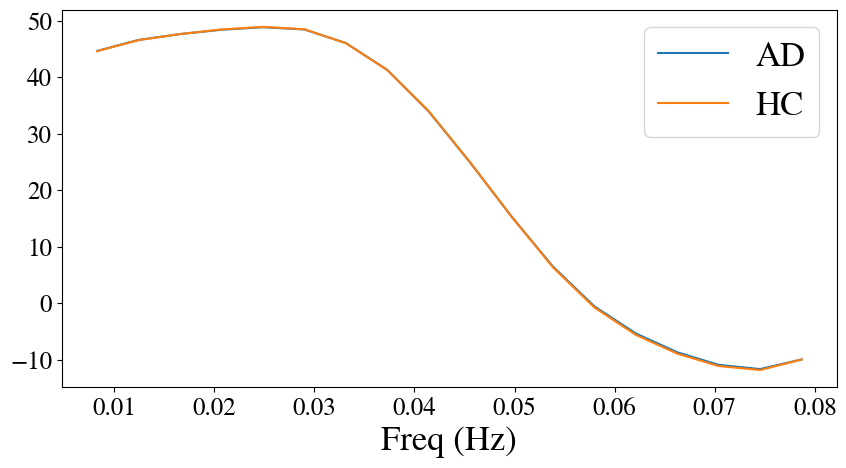

In [46]:
mpsd_perU = psds.mean(axis=2);
AD_psd = mpsd_perU[diag_labs_sub==1].mean(axis=0)
Ctrl_psd = mpsd_perU[diag_labs_sub==6].mean(axis=0)
plt.plot(freqs, AD_psd, label="AD")
plt.plot(freqs, Ctrl_psd, label="HC")
plt.xlabel("Freq (Hz)")
plt.legend()

## Show some significant results

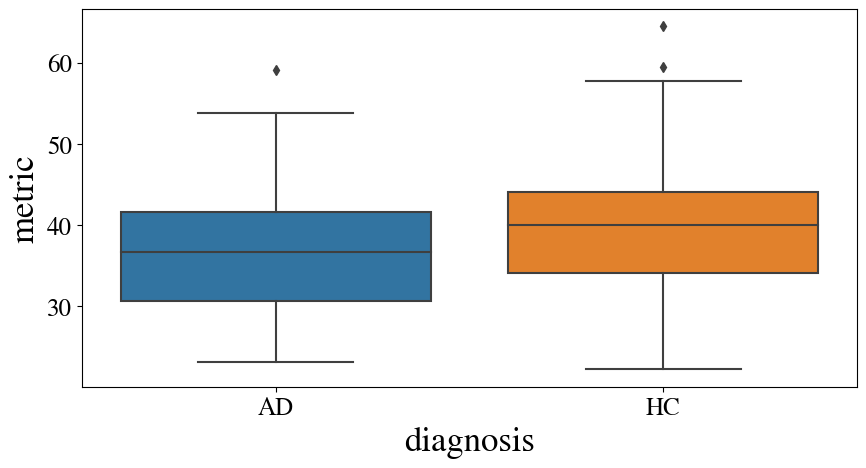

In [50]:
res_df = pd.DataFrame({
        "metric": lam_ests_mean_abs[:, 7], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
sns.boxplot(x="diagnosis", y="metric", data=res_df)
plt.xticks([0, 1], ["AD", "HC"]);

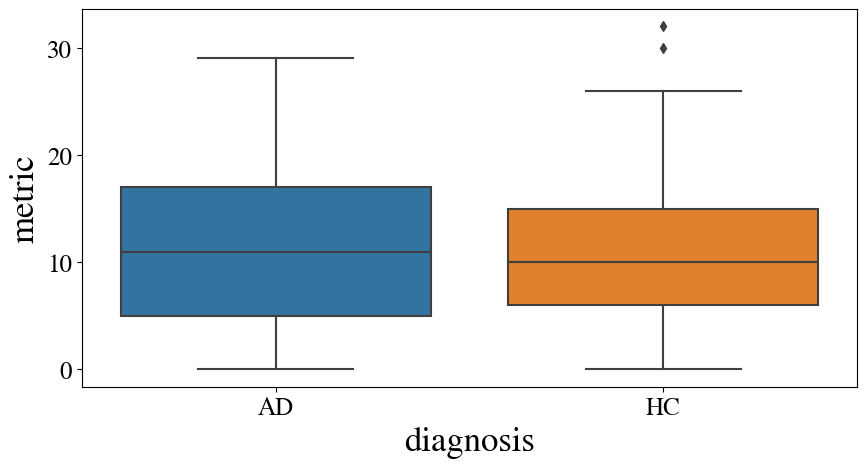

In [51]:
res_df = pd.DataFrame({
        "metric": dwells_perU[:, 6], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
sns.boxplot(x="diagnosis", y="metric", data=res_df)
plt.xticks([0, 1], ["AD", "HC"]);

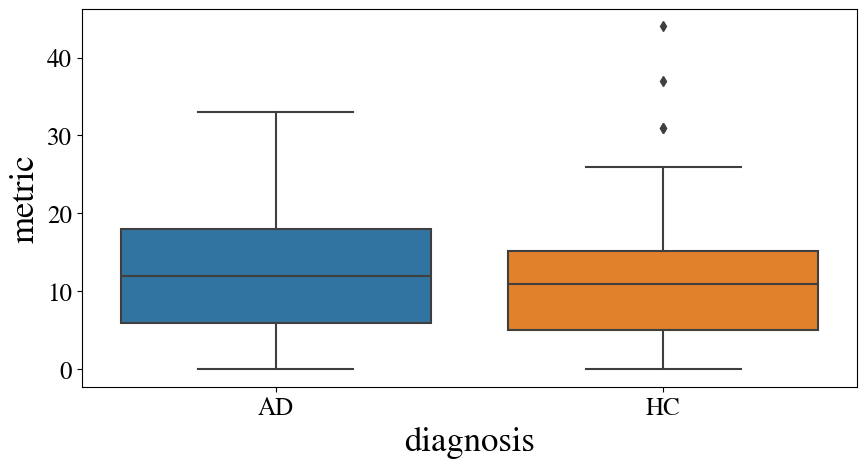

In [49]:
res_df = pd.DataFrame({
        "metric": dwells_perU[:, 0], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
sns.boxplot(x="diagnosis", y="metric", data=res_df)
plt.xticks([0, 1], ["AD", "HC"]);